# Prediction of article prices

Problem definition: Build an algorithm which predicts article prices based on product characteristerics.

In [650]:
import pandas as pd
from sqlalchemy import create_engine
import os
import json
import numpy as np

def load_credentials(path = "aws_rds_credentials.json"):
     with open(path, 'r') as file:
          config = json.load(file)

     # set up credentials
     for key in config.keys():
          os.environ[key] = config[key]

     return


load_credentials()

aws_rds_url = f"postgresql://{os.environ['user']}:{os.environ['password']}@{os.environ['host']}:{os.environ['port']}/{os.environ['database']}?sslmode=require"

# Load a sample dataset
def load_data():
    engine = create_engine(aws_rds_url)
    sql_query = f"""SELECT * 
                    FROM public.tracking_staging 
                    """
    df = pd.read_sql(sql_query, engine)
    return (df)

data = load_data()
data

,product_id,catalog_id,brand_title,date,size_title,color1_id,favourite_count,view_count,created_at,original_price_numeric,price_numeric,package_size_id,service_fee,city,country,color1,status,description,item_closing_action,user_id
0,3943157075,2006.0,CASA,2024-02-21,,16.0,12.0,69.0,2024-01-05,2.0,2.0,1.0,0.80,Cagnes-sur-Mer,France,Caqui,Novo com etiquetas,Neuve avec étiquette,None,21172815.0
1,3861241052,1666.0,IKKS,2024-02-21,S,9.0,1.0,5.0,2023-12-09,5.0,4.0,1.0,0.90,Cagnes-sur-Mer,France,Azul,Muito bom,We are young,None,21172815.0
2,3764399949,1763.0,Scratch,2024-02-21,10 anos / 140 cm,None,1.0,8.0,2023-11-15,15.0,15.0,1.0,1.45,Cagnes-sur-Mer,France,None,Muito bom,Cartes pour apprendre à coder,None,21172815.0
3,3730758676,1764.0,Tsum tsum,2024-02-21,4 anos / 104 cm,None,0.0,7.0,2023-11-08,2.0,2.0,1.0,0.80,Cagnes-sur-Mer,France,None,Muito bom,Anna et Elsa,None,21172815.0
4,3717642430,2339.0,,2024-02-21,,None,0.0,0.0,2023-11-05,3.0,3.0,1.0,0.85,Cagnes-sur-Mer,France,None,Muito bom,Très bon état,None,21172815.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674445,4005800233,1606.0,Revolution,2024-02-21,5 anos / 110 cm,5.0,0.0,1.0,2024-01-21,3.0,3.0,1.0,0.85,Cagnes-sur-Mer,France,Fúcsia,Muito bom,Combishort\nPorté 1 fois 1 heure,None,21172815.0
674446,4005767100,1606.0,Revolution,2024-02-21,5 anos / 110 cm,12.0,0.0,4.0,2024-01-21,10.0,8.0,1.0,1.10,Cagnes-sur-Mer,France,Branco,Muito bom,Show Angel \nPorté 1 fois 1 heure,None,21172815.0
674447,3943168819,158.0,IKKS,2024-02-21,,3.0,1.0,68.0,2024-01-05,10.0,8.0,1.0,1.10,Cagnes-sur-Mer,France,Cinzento,Satisfatório,Cuir veilli,None,21172815.0
674448,3943161668,161.0,Sunshine,2024-02-21,,5.0,0.0,2.0,2024-01-05,2.0,2.0,1.0,0.80,Cagnes-sur-Mer,France,Fúcsia,Muito bom,Très bon état,None,21172815.0


In [651]:
data.drop_duplicates(subset='product_id', inplace=True, keep= "last")
data

,product_id,catalog_id,brand_title,date,size_title,color1_id,favourite_count,view_count,created_at,original_price_numeric,price_numeric,package_size_id,service_fee,city,country,color1,status,description,item_closing_action,user_id
34,3636130842,1590.0,Nabaiji,2024-02-21,12 anos / 152 cm,5.0,5.0,28.0,2023-10-20,1.0,1.0,1.0,0.75,Cagnes-sur-Mer,France,Fúcsia,Muito bom,Très peu porté Sans étiquette,None,21172815.0
317,4058674803,2339.0,,2024-02-21,,None,1.0,1.0,2024-02-03,2.0,2.0,1.0,0.80,Congénies,France,None,Muito bom,Lu 1 fois.\n500p,None,12043348.0
396,4099258457,2676.0,Nike,2024-02-21,42,26.0,34.0,464.0,2024-02-14,160.0,130.0,1.0,7.20,San Nicola La Strada,Italia,Azul claro,Novo com etiquetas,Vendo Nike Mercurial Superfly professionali AC...,None,176350478.0
500,4057150173,2338.0,,2024-02-21,,None,0.0,0.0,2024-02-03,2.0,2.0,2.0,0.80,Congénies,France,None,Bom,Bon état,None,12043348.0
942,4128871518,218.0,Livera,2024-02-21,XL / 42 / 14,2.0,5.0,46.0,2024-02-21,3.0,3.0,1.0,0.85,Haps,Pays-Bas,Castanho,Muito bom,Van Livera\nMaat 42,None,63460095.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674445,4005800233,1606.0,Revolution,2024-02-21,5 anos / 110 cm,5.0,0.0,1.0,2024-01-21,3.0,3.0,1.0,0.85,Cagnes-sur-Mer,France,Fúcsia,Muito bom,Combishort\nPorté 1 fois 1 heure,None,21172815.0
674446,4005767100,1606.0,Revolution,2024-02-21,5 anos / 110 cm,12.0,0.0,4.0,2024-01-21,10.0,8.0,1.0,1.10,Cagnes-sur-Mer,France,Branco,Muito bom,Show Angel \nPorté 1 fois 1 heure,None,21172815.0
674447,3943168819,158.0,IKKS,2024-02-21,,3.0,1.0,68.0,2024-01-05,10.0,8.0,1.0,1.10,Cagnes-sur-Mer,France,Cinzento,Satisfatório,Cuir veilli,None,21172815.0
674448,3943161668,161.0,Sunshine,2024-02-21,,5.0,0.0,2.0,2024-01-05,2.0,2.0,1.0,0.80,Cagnes-sur-Mer,France,Fúcsia,Muito bom,Très bon état,None,21172815.0


In [652]:
#data["elapsed"] = pd.to_datetime(data['date']) - pd.to_datetime(data['created_at']) 
#data["elapsed"] = data["elapsed"].dt.days.astype("int64")

In [653]:
#data = data[["size_title", "color1", "brand_title", "price_numeric", "status", "catalog_id", "package_size_id", "country", "view_count", "favourite_count", "elapsed"]]
data = data[["size_title", "color1", "brand_title", "price_numeric", "status", "catalog_id", "package_size_id", "country"]]

#date_90_days_ago = pd.Timestamp('today') - pd.Timedelta(days=180)
#data['created_at'] = pd.to_datetime(data['created_at'])
#data = data[data['created_at'] < date_90_days_ago]
#data = data.drop("created_at", axis = 1)
data

,size_title,color1,brand_title,price_numeric,status,catalog_id,package_size_id,country
34,12 anos / 152 cm,Fúcsia,Nabaiji,1.0,Muito bom,1590.0,1.0,France
317,,None,,2.0,Muito bom,2339.0,1.0,France
396,42,Azul claro,Nike,130.0,Novo com etiquetas,2676.0,1.0,Italia
500,,None,,2.0,Bom,2338.0,2.0,France
942,XL / 42 / 14,Castanho,Livera,3.0,Muito bom,218.0,1.0,Pays-Bas
...,...,...,...,...,...,...,...,...
674445,5 anos / 110 cm,Fúcsia,Revolution,3.0,Muito bom,1606.0,1.0,France
674446,5 anos / 110 cm,Branco,Revolution,8.0,Muito bom,1606.0,1.0,France
674447,,Cinzento,IKKS,8.0,Satisfatório,158.0,1.0,France
674448,,Fúcsia,Sunshine,2.0,Muito bom,161.0,1.0,France


## Dataframe inspection

Let's use df.info(), describe() and null count to check the properties of the dataframe.

In [654]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69606 entries, 34 to 674449
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   size_title       69585 non-null  object 
 1   color1           58091 non-null  object 
 2   brand_title      69585 non-null  object 
 3   price_numeric    69585 non-null  float64
 4   status           66837 non-null  object 
 5   catalog_id       69585 non-null  float64
 6   package_size_id  66837 non-null  float64
 7   country          66837 non-null  object 
dtypes: float64(3), object(5)
memory usage: 4.8+ MB


In [655]:
data.describe(include = 'object')

,size_title,color1,brand_title,status,country
count,69585,58091,69585,66837,66837
unique,303,28,9156,5,37
top,,Preto,,Muito bom,France
freq,13385,15869,10785,36425,28693


In [656]:
data.isnull().sum()

size_title            21
color1             11515
brand_title           21
price_numeric         21
status              2769
catalog_id            21
package_size_id     2769
country             2769
dtype: int64

In [657]:
#data["package_size_id"] = data["package_size_id"].fillna(value = -1)
#data["country"] = data["country"].fillna(value = "null")

## Issues so far:

- catalog_id is int64, other predictors are object. Need to convert them to categorical before feeding to LightGBM
- color1_id has missing values (why?)
    - after inspecting and being knowledgeable about the data, there are articles which by nature do not have colors (such as books)
- the most popular size_title is ""
    - after inspecting I realize this has to do with "sizeless" items such as books as well
- the most popular brand_title is ""
    - this means the article doesn't have a brand. this can have several reasons, not only due to the misc items but also I believe Vinted allowed the user to publish items with empty brands at some point (I haven't confirmed this)
- size_title has 230 unique values which is a lot, let's take a look into that later
    - why is that?
- brand_title has 4.7k unique values which is also a lot
    - why is that?
## Approaches

- change dtypes
- create a dummy color1_id and assign it to articles missing color1_id (filling with value 0)
- replacing "" size_title with "no_size" for better semantic representation (otherwise users are left to guess what it means)
- replacing ""brand_title with "no_brand" for the same reason

In [658]:
# replacing color1_id with value 0
#data["color1"] = data["color1"].fillna(value = 0)
data.isnull().sum()

size_title            21
color1             11515
brand_title           21
price_numeric         21
status              2769
catalog_id            21
package_size_id     2769
country             2769
dtype: int64

In [659]:
data["size_title"] = data["size_title"].replace("", "no_size")
data["brand_title"] = data["brand_title"].replace("", "no_brand")
data


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,size_title,color1,brand_title,price_numeric,status,catalog_id,package_size_id,country
34,12 anos / 152 cm,Fúcsia,Nabaiji,1.0,Muito bom,1590.0,1.0,France
317,no_size,None,no_brand,2.0,Muito bom,2339.0,1.0,France
396,42,Azul claro,Nike,130.0,Novo com etiquetas,2676.0,1.0,Italia
500,no_size,None,no_brand,2.0,Bom,2338.0,2.0,France
942,XL / 42 / 14,Castanho,Livera,3.0,Muito bom,218.0,1.0,Pays-Bas
...,...,...,...,...,...,...,...,...
674445,5 anos / 110 cm,Fúcsia,Revolution,3.0,Muito bom,1606.0,1.0,France
674446,5 anos / 110 cm,Branco,Revolution,8.0,Muito bom,1606.0,1.0,France
674447,no_size,Cinzento,IKKS,8.0,Satisfatório,158.0,1.0,France
674448,no_size,Fúcsia,Sunshine,2.0,Muito bom,161.0,1.0,France


## Taking a deeper look into size title

Size title has unbalanced labels.
- Sizes can be further divided into product types. For instance, we have:
    - M, XL, S, etc which are the standard clothing sizes
    - no_size for the products which do not have size labels
    - numeric sizes (40, 41) which refers to footwear
    - kids sizes (8 anos, 12 anos, etc)
    - cup sizes (95D, 80B)
    - jewelry (which im assuming 30 mm diameter refers to)
    - volume units (40 x 45 cm)
    - weight units (9-18kgs)
    - jeans sizes (waist measurements W33)

In [660]:
import plotly.express as px

# Assuming your DataFrame is called data
fig = px.bar(data['size_title'].value_counts(), 
             x=data['size_title'].value_counts().index, 
             y=data['size_title'].value_counts().values,
             labels={'x': 'Size Title', 'y': 'Count'},
             title='Count of Size Title')
fig

## Taking a deeper look into brand title

Brand titles has too many brands.
- A lot of the brands aren't even brands (such as dri-fit, b(?), GYM, MI(?), etc)
- There are brands that mean the same thing (such as local, locale or any other meaning of thrift clothing)

In [661]:
fig = px.bar(data['brand_title'].value_counts(), 
             x=data['brand_title'].value_counts().index, 
             y=data['brand_title'].value_counts().values,
             labels={'x': 'Brand Title', 'y': 'Count'},
             title='Count of Brand Title')
fig

## Approaches to size titles

- Feature engineering
    - We can easily split garments from shoes, if we consider shoes have only numeric values assigned to sizes
- Remove size classes below a certain threshold

In [662]:
label_counts = data['size_title'].value_counts()

# Filter the labels with more than 100 occurrences
labels_more_than_100 = label_counts[label_counts > 100].index.tolist()

# Filter the DataFrame based on the selected labels
data = data[data['size_title'].isin(labels_more_than_100)]
data['size_title'].unique()

array(['12 anos / 152 cm', 'no_size', '42', 'XL / 42 / 14', 'XS / 34 / 6',
       'L', 'XL', 'M / 38 / 10', 'S / 36 / 8', '3 anos / 98 cm',
       '4 anos / 104 cm', '3-6 meses / 62\xa0cm', '6-9 meses / 68 cm',
       '6 anos / 116 cm', '5 anos / 110 cm', '24-36 meses / 92 cm',
       '9-12 meses / 74\xa0cm', '18-24 meses / 86\xa0cm',
       '8 anos / 128 cm', 'L / 40 / 12', 'M', '9 anos / 134 cm',
       '14 anos / 164 cm', 'S', '45', '36', '43', '37',
       'Até 1 mês / 50\xa0cm', '42,5', 'XXXL', '40', '39',
       'XXL / 44 / 16', 'Tamanho único', '41', 'PT 42 | W32',
       'PT 46 | W36', '10 anos / 140 cm', 'Outro', '38', 'XXXL / 46 / 18',
       '44', 'XS', 'XXL', '12-18 meses / 80\xa0cm', 'PT 44 | W34',
       'Ajustável', 'PT 40 | W30', '44,5', '5XL / 50 / 22',
       '11 anos / 146 cm', '13 anos / 158 cm', 'XXS / 32 / 4', '35',
       '7 anos / 122 cm', '1-3 meses / 56\xa0cm', '16 anos / 176 cm',
       '4XL / 48 / 20', '38.5'], dtype=object)

In [663]:
fig = px.bar(data['brand_title'].value_counts(), 
             x=data['brand_title'].value_counts().index, 
             y=data['brand_title'].value_counts().values,
             labels={'x': 'Brand Title', 'y': 'Count'},
             title='Count of Brand Title')
fig

## Approaches to brand titles

- Remove size classes below a certain threshold

In [664]:
label_counts = data['brand_title'].value_counts()

# Filter the labels with more than 100 occurrences
labels_more_than_100 = label_counts[label_counts > 100].index.tolist()

# Filter the DataFrame based on the selected labels
data = data[data['brand_title'].isin(labels_more_than_100)]
data['brand_title'].unique()

array(['no_brand', 'Nike', 'Mango', 'Celio', 'United Colors of Benetton',
       'Jennyfer', 'Tissaia', 'Orchestra', 'Gémo', 'Kiabi', 'Disney',
       "Tape à l'œil", 'C&A', 'Cache Cache', 'adidas', 'Zara', 'Pimkie',
       'sans marque', 'Local', 'Jordan', 'TEX', 'Hollister', 'IKKS',
       'Shein', 'Bershka', 'Stradivarius', 'Etam', 'Vintage',
       'Massimo Dutti', 'Vero Moda', 'H&M', "Levi's", 'Timberland',
       'Carhartt', 'Lacoste', 'Made In Italy', 'Esprit', 'Ralph Lauren',
       'Puma', 'Tommy Hilfiger', 'Champion', 'Camaïeu', 'Decathlon',
       'GUESS', 'Uniqlo', 'Converse', 'Vans', 'Scarpe', 'Pull & Bear',
       'Primark', 'Calvin Klein', 'Terranova', 'Donna',
       'Vintage Dressing', 'Naf Naf', 'ONLY', 'Inconnu', 'Desigual',
       'The North Face', 'Ravensburger', 'Promod', 'Springfield',
       'Lefties', 'Jack & Jones', 'Nike Air', 'Superdry', 'Undiz',
       'Okaïdi', 'In Extenso', 'Bonobo', 'Jules', 'ASOS', 'OVS',
       'Playmobil'], dtype=object)

In [665]:
label_counts = data['catalog_id'].value_counts()

# Filter the labels with more than 100 occurrences
labels_more_than_100 = label_counts[label_counts > 100].index.tolist()

# Filter the DataFrame based on the selected labels
data = data[data['catalog_id'].isin(labels_more_than_100)]
data["catalog_id"].unique()
#pd.DataFrame({'catalog_id': labels}).to_csv("../prediction_service/catalog_id.csv")
#print(labels)

array([2339., 2338.,  189., 2364., 1811.,  196.,  222., 1065., 1554.,
       1535.,  221.,  197., 2337., 2342., 2350., 2346., 2362., 2349.,
       1242., 1696.,  163., 1809.,  176., 1055.,  225., 1071., 1775.,
        199., 1843., 1043., 2662., 1806., 1056., 1812., 1079.,  198.,
       1803.,  267.,  190.,  228., 2632., 2351., 2360., 2344., 1845.,
        584., 1807., 1672., 1804., 2526., 1801.,  227., 1059.,  529.,
       1846.,  194., 1066., 1057., 1779., 1204., 2618.,  532.,  164.,
       1668., 1662., 2343.,  538., 2333., 1844., 2357.,  191.,  178.,
       1140., 2949.,  156.,  224.,  185., 1842.,  223.,  534.,  582.,
       1821., 1223., 1730., 1542., 1805.,  158., 1041.,   18., 1058.,
       2336., 2355., 2363.,  123., 1835.,  165., 1813., 1099.,   89.,
       1042., 1132., 2358.,  543., 2328.])

In [666]:
pd.DataFrame(data["package_size_id"].unique()).to_csv("../prediction_service/package_size_id.csv")
pd.DataFrame(data["country"].unique()).to_csv("../prediction_service/country.csv")
pd.DataFrame(data["color1"].unique()).to_csv("../prediction_service/color1.csv")
pd.DataFrame(data["status"].unique()).to_csv("../prediction_service/status.csv")
pd.DataFrame(data["catalog_id"].unique()).to_csv("../prediction_service/catalog_id.csv")
pd.DataFrame(data["brand_title"].unique()).to_csv("../prediction_service/brand_title.csv")
pd.DataFrame(data['size_title'].unique()).to_csv("../prediction_service/size_title.csv")

In [667]:
from sklearn.model_selection import train_test_split
# LightGBM also can handle categorical data directly We go to probe its inner method

# Transform categorical features into the appropriate type that is expected by LightGBM
for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')
data["catalog_id"] = data["catalog_id"].astype("category")
data["package_size_id"] = data["package_size_id"].astype("category")
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 22785 entries, 317 to 674449
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   size_title       22785 non-null  category
 1   color1           17405 non-null  category
 2   brand_title      22785 non-null  category
 3   price_numeric    22785 non-null  float64 
 4   status           21878 non-null  category
 5   catalog_id       22785 non-null  category
 6   package_size_id  21878 non-null  category
 7   country          21878 non-null  category
dtypes: category(7), float64(1)
memory usage: 524.7 KB


In [679]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["price_numeric"]), 
                                                    data["price_numeric"], 
                                                    test_size=0.2, 
                                                    random_state=42)
X_test.iloc[-5:-1].to_pickle("../prediction_service/test_sample.pkl")
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18228 entries, 659817 to 640489
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   size_title       18228 non-null  category
 1   color1           13896 non-null  category
 2   brand_title      18228 non-null  category
 3   status           17493 non-null  category
 4   catalog_id       18228 non-null  category
 5   package_size_id  17493 non-null  category
 6   country          17493 non-null  category
dtypes: category(7)
memory usage: 280.0 KB


In [669]:
X_train

,size_title,color1,brand_title,status,catalog_id,package_size_id,country
659817,6 anos / 116 cm,Preto,TEX,Muito bom,1662.0,1.0,France
512882,no_size,NaN,no_brand,Muito bom,2363.0,2.0,España
493199,S / 36 / 8,Cinzento,Bershka,Muito bom,532.0,1.0,Belgique
397480,no_size,NaN,no_brand,Muito bom,2364.0,1.0,Francia
308346,L,Creme,H&M,Satisfatório,267.0,1.0,France
...,...,...,...,...,...,...,...
606496,9-12 meses / 74 cm,Azul-marinho,Primark,Muito bom,1672.0,1.0,França
671055,no_size,Castanho,Tommy Hilfiger,Bom,158.0,2.0,Italia
428314,M,Branco,Ralph Lauren,Muito bom,1801.0,1.0,França
142191,no_size,NaN,no_brand,Bom,2333.0,1.0,France


In [670]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import joblib

d_train=lgb.Dataset(X_train, 
                    label=y_train,
                    params={"max_bin":128})

# Define parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',  # Root Mean Squared Error    
    'n_estimators': 600,
    'max_depth': 18,
    'num_leaves': 2**6,
    'learning_rate': 0.01
}

clf=lgb.train(params,
              d_train) 

# Prediction on the valid set
y_pred=clf.predict(X_test)

# postprocess function
y_pred = y_pred.astype(np.int16)
errors = y_pred - y_test

# save model
joblib.dump(clf, '../prediction_service/lgb.pkl')

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 18228, number of used features: 7
[LightGBM] [Info] Start training from score 13.246324
Mean Squared Error: 363.5159095896423


In [671]:
results = pd.DataFrame([y_pred, y_test]).T
results.columns = ["Prediction", "Test"]
results

,Prediction,Test
0,9.0,4.0
1,5.0,5.0
2,17.0,26.0
3,8.0,7.0
4,10.0,6.0
...,...,...
4552,15.0,25.0
4553,8.0,3.0
4554,4.0,3.0
4555,2.0,1.0


Text(0.5, 1.0, 'Actual vs. Predicted')

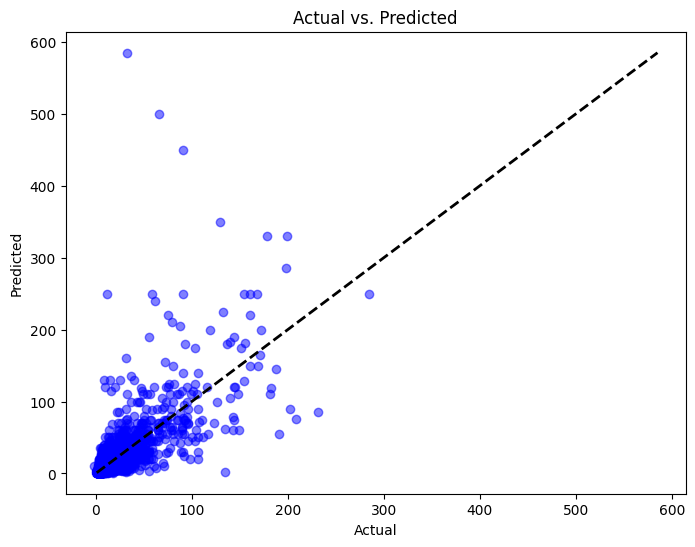

In [672]:
import matplotlib.pyplot as plt

# y_pred/y_test QQ plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, color='blue', alpha=0.5)
plt.plot([y_test.min(), 
          y_test.max()], 
          [y_test.min(), 
           y_test.max()], 
           'k--', 
           lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

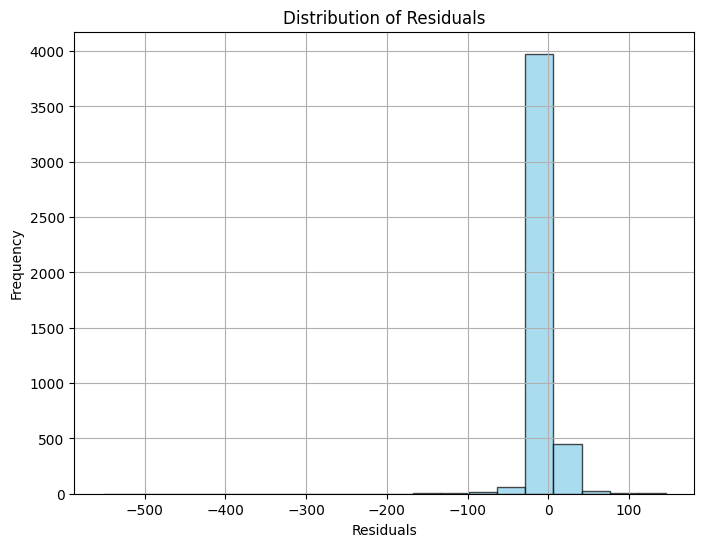

In [673]:
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)

In [674]:
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
pd.DataFrame(shap_values, columns= X_test.columns).apply(np.abs).mean(axis = 0)

size_title         1.030175
color1             0.476042
brand_title        6.272065
status             2.338599
catalog_id         4.671936
package_size_id    1.864240
country            0.536807
dtype: float64

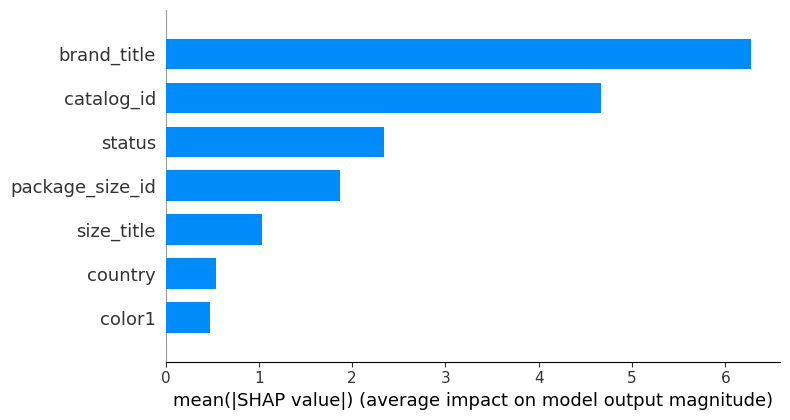

In [675]:
shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=X_test.columns,
                  plot_type = "bar")

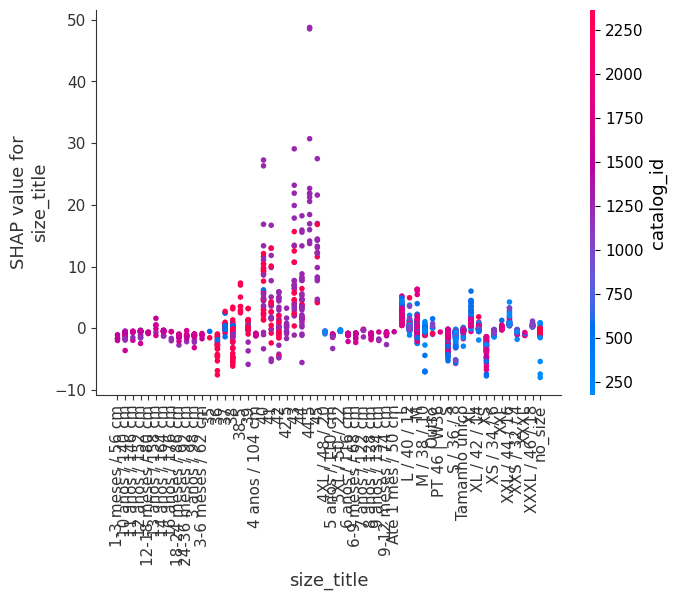

In [676]:
shap.dependence_plot("size_title", shap_values, X_test, interaction_index="catalog_id")